In [25]:
%matplotlib notebook

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import IPython
import IPython.display
import IPython.core.display
from os.path import join, exists
from os import makedirs

output_dir = '../../outf/HW2-4'
if not exists(output_dir):
    makedirs(output_dir)

In [26]:
def make_animation(plotx, E, xl=(0, 1), yl=(0, 1), inter=25, display=False):
    '''
    takes a graph and motion of vertexes in 2D and returns an animation
    E: list of edges (each edge is a pair of vertexes)
    plotx: a matrix of states ordered as (x1, y1, x2, y2, ..., xn, yn) in the rows and time in columns
    xl and yl define the display boundaries of the graph
    inter is the interval between each point in ms
    '''
    fig = mpl.figure.Figure()
    mpl.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=xl, ylim=yl)
    ax.grid()

    list_of_lines = []
    for i in E: #add as many lines as there are edges
        line, = ax.plot([], [], 'o-', lw=2)
        list_of_lines.append(line)

    def animate(i):
        for e in range(len(E)):
            vx1 = plotx[2*(E[e][0]-1),i]
            vy1 = plotx[2*(E[e][0]-1)+1,i]
            vx2 = plotx[2*(E[e][1]-1),i]
            vy2 = plotx[2*(E[e][1]-1)+1,i]
            list_of_lines[e].set_data([vx1,vx2],[vy1,vy2])
        return list_of_lines

    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=inter, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    if(display==True):
        IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))
    return ani

In [27]:
class SecondOrderControl:
    def __init__(self, G, poses, zref, time=15, dt=0.01, k=0.5):
        self.G = G
        self.zref = zref
        self.time = time
        self.dt = dt
        self.k = k
        self.N = G.number_of_nodes()

        self.T = int(time / dt)
        self.u = np.zeros((self.T, self.N, 2))
        self.x = np.zeros((self.T, self.N, 2))
        self.x[0] = poses

        self.L = nx.laplacian_matrix(G).toarray()
        self.D = nx.incidence_matrix(G, oriented=True).toarray()

    def draw_initial_conditions(self):
        pos = {}
        
        for i, position in enumerate(self.x[0]):
            pos[i+1] = position
        pos_shadow = {key: (value[0] + 0.005, value[1] + 0.005) for key, value in pos.items()}
        nx.draw(self.G, pos_shadow, with_labels=False, node_size=600, node_color='none', edgecolors='gray', edge_color='gray', width=3.0, alpha=0.5)

        nx.draw(self.G, pos, with_labels=True, node_size=600, edge_color='red', width=2.0, linewidths=3.0, edgecolors='black', node_color='white', font_size=12, font_weight='bold')
        plt.title('Initial Conditions')
        plt.show()

    def run_simulation(self):
        for t in range(1, self.T):
            self.u[t - 1] = -self.k * self.L @ self.x[t - 1] + self.k * self.D @ self.zref
            self.x[t] = self.x[t - 1] + self.u[t - 1] * self.dt

    def plot_results(self, filename=None, display=True):
        E = list(self.G.edges())
        X = np.zeros((2 * self.N, self.T))
        for i in range(self.T):
            for j in range(self.N):
                X[2 * j, i] = self.x[i, j, 0]
                X[2 * j + 1, i] = self.x[i, j, 1]

        ani = make_animation(X, E, xl=(0, 5), yl=(0, 5), inter=10, display=display)
        if filename:
            writervideo = animation.FFMpegWriter(fps=20, codec='h264', extra_args=['-pix_fmt', 'yuv420p'])
            ani.save(filename, writer=writervideo)

        return ani

## Initial Condition

<IPython.core.display.Javascript object>


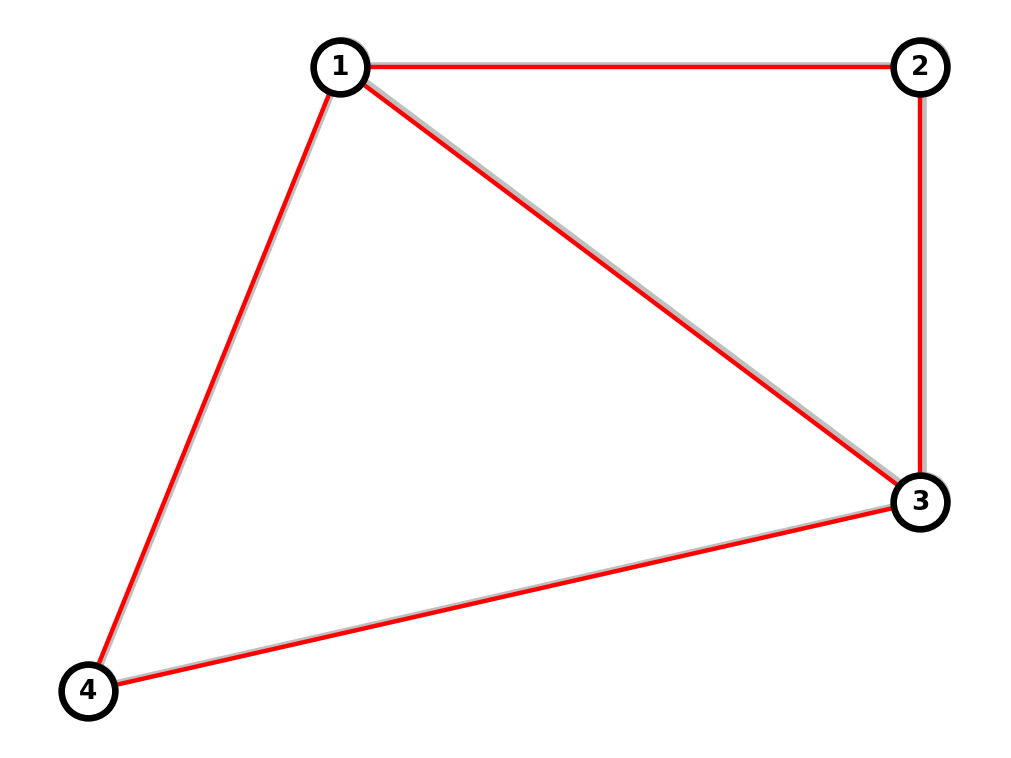

In [28]:
N = 4
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (2, 3), (1, 3), (1, 4), (3, 4)])
a=7/2-np.sqrt(7/8)
poses=np.array([[3,4],[4,4],[4,3],[a,a]])
zref = np.array([[1, 1], [np.sqrt(2), np.sqrt(2)], [1.5, 1.5], [1, 1], [1.5, 1.5]])

control = SecondOrderControl(G, poses,zref)
control.draw_initial_conditions()

## Simulation

In [29]:
control.run_simulation()
control.plot_results(filename=join(output_dir,'simulations_animation.mp4'))

MovieWriter stderr:
[libopenh264 @ 0x55c97b323400] Incorrect library version loaded
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '100.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpgjnngaay/temp.m4v']' returned non-zero exit status 1.